# PINN Solution of the Kuramoto-Sivashinsky equation

This PyTorch code demonstrates the application of physically-informed neural networks (PINN) in the solution of a well-known Kuramoto-Sivashinsky equation with periodic boundary condition
\begin{aligned}
  &u_t =  -u_{xx} - u_{xxxx} - uu_x, \quad (t, x) \in [0, T]\times[-L, L]\\
  &u(0, x) = u_0(x), \quad \forall x \in [-L, L] \\
  &u(t, -L) = u(t, L), \quad u_x(t, -L) = u_x(t, L), \quad \forall t \in [0, T]
\end{aligned}

## Libraries and Dependencies

In [1]:
from itertools import chain
from collections import OrderedDict
import time
import numpy as np
import scipy as sp
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
import torch
import torch.optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
np.random.seed(1234)

In [2]:
# MPS or CUDA or CPU
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
#
print(f"Working on {device}")

Working on mps


In [3]:
xlo = 0
xhi = 32*np.pi
period = xhi - xlo
tlo = 0.0
thi = 10.0
pi_ten = torch.tensor(np.pi).float().to(device)

u0 = lambda x: np.cos(x/16)*(1 + np.sin((x-1)/16))
u0_ten = lambda x: torch.cos(x/16)*(1 + torch.sin((x-1)/16))

## Physics-informed Neural Networks

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        # parameters
        self.depth = len(layers) - 1
        # set up layer order dict
        self.activation = torch.nn.Tanh
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        self.layers[0].weight = torch.load('initial_weights_PBC.pt')
    def forward(self, x):
        out = self.layers(x)
        return out

In [5]:
class PhysicsInformedNN():
    def __init__(self, period, m, X_PDE, layers):
        # Prepare the periodic layer
        m_vec = np.expand_dims(np.arange(1, m + 1), axis = 0)
        self.ms = torch.tensor(2.0 * np.pi/period * m_vec).float().to(device)
        # PDE data, gradients will be computed on these points so requires_grad = True
        self.t_PDE = torch.tensor(X_PDE[:, 0:1], requires_grad=True).float().to(device)
        self.x_PDE = torch.tensor(X_PDE[:, 1:2], requires_grad=True).float().to(device)
        N_PDE = X_PDE.shape[0]
        self.LW_PDE = torch.nn.ParameterList([torch.nn.Parameter(torch.ones(N_PDE, 1).float(), requires_grad=True).to(device)])

       
       
    
        layers[0] = int(2 * m + 2)
        self.layers = layers
        
    
        # deep neural networks
        self.dnn = DNN(layers).to(device)    
        # prepare the optimizer
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), lr = 1e-3)
        self.optimizer_LW_PDE = torch.optim.Adam(self.LW_PDE.parameters(), lr = 5e-3)
        # add a learning rate scheduler
        self.optimizer_LBFGS = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=10000, 
            max_eval=5000, 
            history_size=50,
            tolerance_grad=1e-7, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )        
        self.scheduler = lr_scheduler.ExponentialLR(self.optimizer_Adam, gamma=0.99)
       
        self.iter = 0
    # update alpha
    def NN_set_alpha(self, alpha):
        self.alpha = torch.tensor(alpha).float().to(device)
    # update iteration number
    def NN_reset_iter(self):
        self.iter = 0
    # evaluater neural network
    # with transformation to include the initial condition
    def NN_eval(self, t, x):  
        x_trans = torch.matmul(x, self.ms)
        uNN = self.dnn(torch.cat([t, torch.ones_like(x), torch.cos(x_trans), torch.sin(x_trans)], dim = 1))
        u0_torch = u0_ten(x)
        u = u0_torch*torch.exp(-t) + t * uNN
        return u
    # compute the PDE
    def pde_eval(self, t, x):
        """ The pytorch autograd version of calculating residual """
        u    = self.NN_eval(t, x)
        # compute the derivatives for u
        u_t  = torch.autograd.grad(u,   t, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        u_x  = torch.autograd.grad(u,   x, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        u_xxx = torch.autograd.grad(u_xx, x, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        u_xxxx = torch.autograd.grad(u_xxx, x, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        f    = u_t + u_xx + u_xxxx + u * u_x 
       
        return f
    # compute the total loss for the second-order optimizer
    def loss_func(self):
        # reset the gradient
        self.optimizer_LBFGS.zero_grad()
        # compute PDE loss
        pde_pred = self.pde_eval(self.t_PDE, self.x_PDE)
        loss_PDE = torch.mean(torch.square(self.LW_PDE[0] * pde_pred))    
        # compute the total loss, it can be weighted
        loss = loss_PDE
        # backward propagation
        loss.backward()
        # increase the iteration counter
        self.iter += 1
        # output
        # output the progress
        if self.iter % 1000 == 0:
            print('Iter %5d, Total: %10.4e, PDE: %10.4e' % (self.iter, loss.item(), loss_PDE.item()))
        return loss
    #
    def train(self, nIter):
        # start the training with Adam first
        self.dnn.train()
        print('Starting with Adam')
        for epoch in range(nIter):
           
                # compute PDE loss
            pde_pred = self.pde_eval(self.t_PDE, self.x_PDE)
            
            loss_PDE = torch.mean(torch.square(self.LW_PDE[0] * pde_pred)) 
                # compute the total loss, it can be weighted
            loss = loss_PDE
                # Backward and optimize
            self.optimizer_Adam.zero_grad()
            self.optimizer_LW_PDE.zero_grad()
            loss.backward()
            self.optimizer_Adam.step() 
            
           
            self.LW_PDE[0].grad.data = -self.LW_PDE[0].grad.data
           
            self.optimizer_LW_PDE.step()
                # output the progress
            if (epoch + 1) % 1000 == 0:
                print('Iter %5d,  PDE: %10.4e' % (epoch + 1, loss_PDE.item()))
                print('For PDE, min LW: %10.4e, max LW: %10.4e' %(torch.min(self.LW_PDE[0]).item(), torch.max(self.LW_PDE[0]).item()))

                # change the learning rate
                self.scheduler.step()
       # self.optimizer_LBFGS.step(self.loss_func) 
        print('Starting with L-BFGS')
        self.start_time = time.time()
        self.optimizer_LBFGS.step(self.loss_func)      
        
    def predict(self, X):
        t = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        x = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.dnn.eval()
        u = self.NN_eval(t, x)
        u = u.detach().cpu().numpy()
        return u

## Configurations

In [6]:
def get_points_for_training(tlo, thi, xlo, xhi, N_IC, N_BC, N_PDE):
    # for IC, (t, x) \in {tlo}x\Omega
    x_IC = np.expand_dims(np.linspace(xlo, xhi, N_IC), axis = 1)
    t_IC = tlo * np.ones_like(x_IC)
    ptsIC = np.hstack((t_IC, x_IC))
    u_IC = u0(x_IC)
    # for BC, (t, x) \in {xlo}x(0, T]
    t_BC = np.linspace(tlo, thi, N_BC + 1)
    t_BC = np.expand_dims(t_BC[1:], axis = 1)
    x_BC = xlo * np.ones_like(t_BC)
    ptsBC = np.hstack((t_BC, x_BC))
    # for collocation pts, (t, x) \in (0, T)x\Omega
    pts_rand = lhs(2, N_PDE)
    t_PDE = tlo + (thi - tlo) * pts_rand[:, 0:1]
    x_PDE = xlo + (xhi - xlo) * pts_rand[:, 1:2]
    ptsPDE = np.hstack((t_PDE, x_PDE))
    return ptsIC, u_IC, ptsBC, ptsPDE

## Training

In [7]:
layers = [2, 32, 32, 32, 32, 32, 32, 32, 1]
m = 16
ptsIC=np.load('ptsIC.npy')
ptsBC=np.load('ptsBC.npy')
ptsPDE=np.load('random_data.npy')
ptsPDE = np.vstack((ptsIC,ptsPDE))
ptsPDE = np.vstack((ptsBC,ptsPDE))

model = PhysicsInformedNN(period,m,ptsPDE,layers)
model.train(50000)

Starting with Adam
Iter  1000,  PDE: 5.5756e-03
For PDE, min LW: 1.2995e+00, max LW: 6.8106e+00
Iter  2000,  PDE: 4.1932e-03
For PDE, min LW: 1.3758e+00, max LW: 1.0287e+01
Iter  3000,  PDE: 6.5135e-03
For PDE, min LW: 1.4156e+00, max LW: 1.4749e+01
Iter  4000,  PDE: 6.1428e-03
For PDE, min LW: 1.4867e+00, max LW: 1.9732e+01
Iter  5000,  PDE: 9.8382e-03
For PDE, min LW: 1.5890e+00, max LW: 2.5584e+01
Iter  6000,  PDE: 7.4322e-03
For PDE, min LW: 1.7228e+00, max LW: 2.9560e+01
Iter  7000,  PDE: 1.3790e-02
For PDE, min LW: 1.9176e+00, max LW: 3.1454e+01
Iter  8000,  PDE: 3.8672e-02
For PDE, min LW: 2.2559e+00, max LW: 3.6385e+01
Iter  9000,  PDE: 3.1494e-02
For PDE, min LW: 2.4154e+00, max LW: 4.0312e+01
Iter 10000,  PDE: 2.7184e-02
For PDE, min LW: 2.6505e+00, max LW: 4.5188e+01
Iter 11000,  PDE: 2.3643e-02
For PDE, min LW: 3.1326e+00, max LW: 5.0379e+01
Iter 12000,  PDE: 5.8194e-02
For PDE, min LW: 3.8818e+00, max LW: 5.5468e+01
Iter 13000,  PDE: 1.4691e-02
For PDE, min LW: 4.9785e+00,

In [8]:
# apply PINN to the same grid as the quadrature solution for comparison
t = np.linspace(tlo, thi, 101)
x = np.linspace(xlo, xhi, 201)
T, X = np.meshgrid(t, x)
pts_flat = np.hstack((T.flatten()[:, None], X.flatten()[:, None]))
u_pred = model.predict(pts_flat)
                   
u_pred = griddata(pts_flat, u_pred.flatten(), (T, X), method='cubic')

## Visualizations

In [9]:
data = scipy.io.loadmat('/Users/abraham/Desktop/PINN/New_Data/KS_1D_t10.mat')
t = data['t'].flatten()[:,None]
x2 = data['x'].flatten()[:,None]
exact_sol = np.real(data['exact_sol']).T

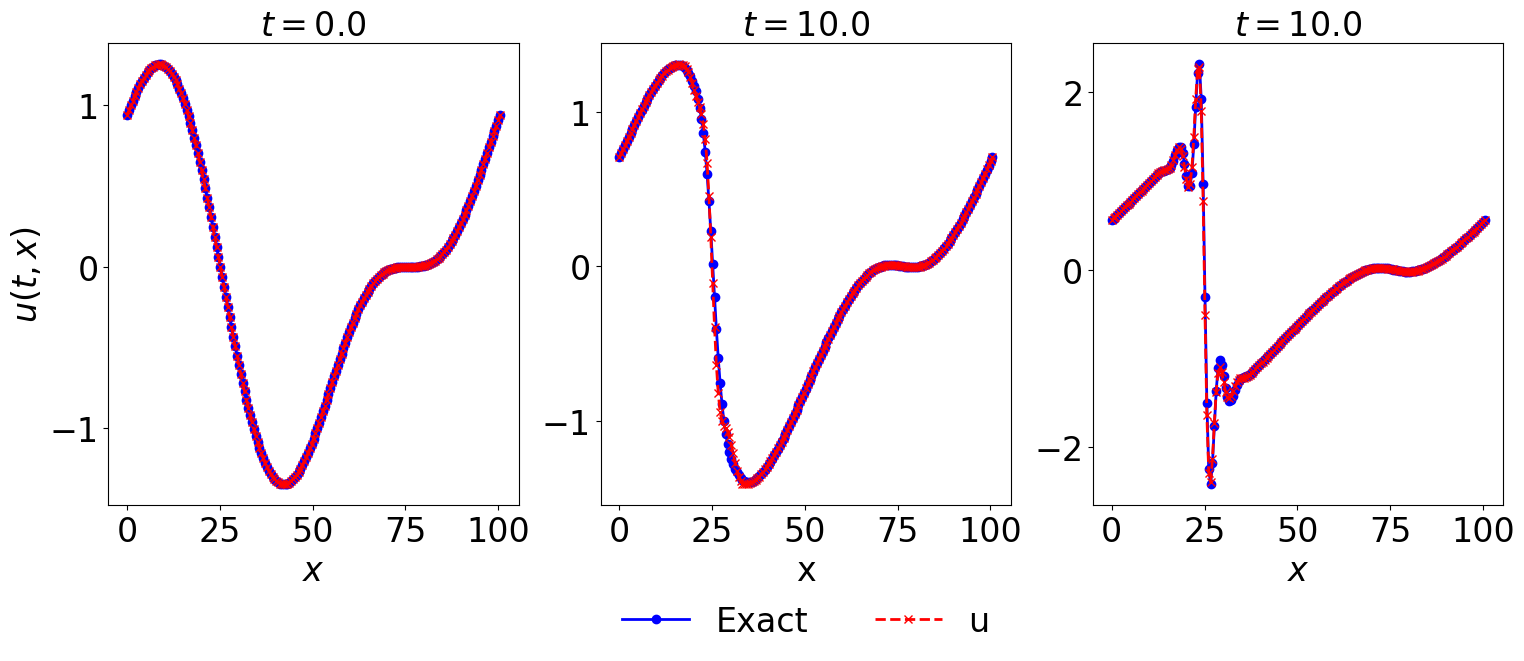

In [15]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(18, 6))
#
ax = plt.subplot(1, 3, 1)
ax.plot(x2, exact_sol[0,:], 'bo-', linewidth = 2, label = 'Exact')       
ax.plot(x, u_pred[:, 0], 'rx--', linewidth = 2, label = 'u')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = %.1f$' %(t[0]), fontsize = 24)


plt.locator_params(axis = 'y', nbins = 5)
plt.locator_params(axis = 'x', nbins = 5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(24)

ax = plt.subplot(1, 3, 2)
ax.plot(x,exact_sol[50,:], 'bo-', linewidth = 2, label = 'Exact')       
ax.plot(x, u_pred[:, 50], 'rx--', linewidth = 2, label = 'u')

ax.set_xlabel('x')




ax.set_title('$t = %.1f$' %(t[100]), fontsize = 24)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 24}
)
plt.locator_params(axis = 'y', nbins = 5)
plt.locator_params(axis = 'x', nbins = 5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(24)

ax = plt.subplot(1, 3, 3)
ax.plot(x,exact_sol[100,:], 'bo-', linewidth = 2, label = 'Exact')       
ax.plot(x, u_pred[:, 100], 'rx--', linewidth = 2, label = 'u')

ax.set_xlabel('$x$')




ax.set_title('$t = %.1f$' %(t[100]), fontsize = 24)
plt.locator_params(axis = 'y', nbins = 5)
plt.locator_params(axis = 'x', nbins = 5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(24)

plt.show()
fig.savefig('KS_1D_BL+PBC+IC1+SA.png',format='png')

In [11]:
def relative_error_l2(pred,exact):
    error_l2 = np.sqrt(np.sum(np.power(pred - exact,2)))
    relative = error_l2/np.sqrt(np.sum(np.power(exact,2)))
    return relative
def relative_error_l1(pred,exact):
    error_l1 = np.sum(np.abs(pred-exact))
    relative = error_l1/np.sum(np.abs(exact))
    return relative
def relative_error_linf(pred,exact):
    error_linf = np.max(np.abs(pred-exact))
    relative = error_linf/np.max(np.abs(exact))
    return relative

In [12]:
print(f'l2: {relative_error_l2(u_pred.T,exact_sol)}')
print(f'l1: {relative_error_l1(u_pred.T,exact_sol)}')
print(f'linf: {relative_error_linf(u_pred.T,exact_sol)}')

l2: 0.04042826671408972
l1: 0.014640982835712194
linf: 0.13073756393871916


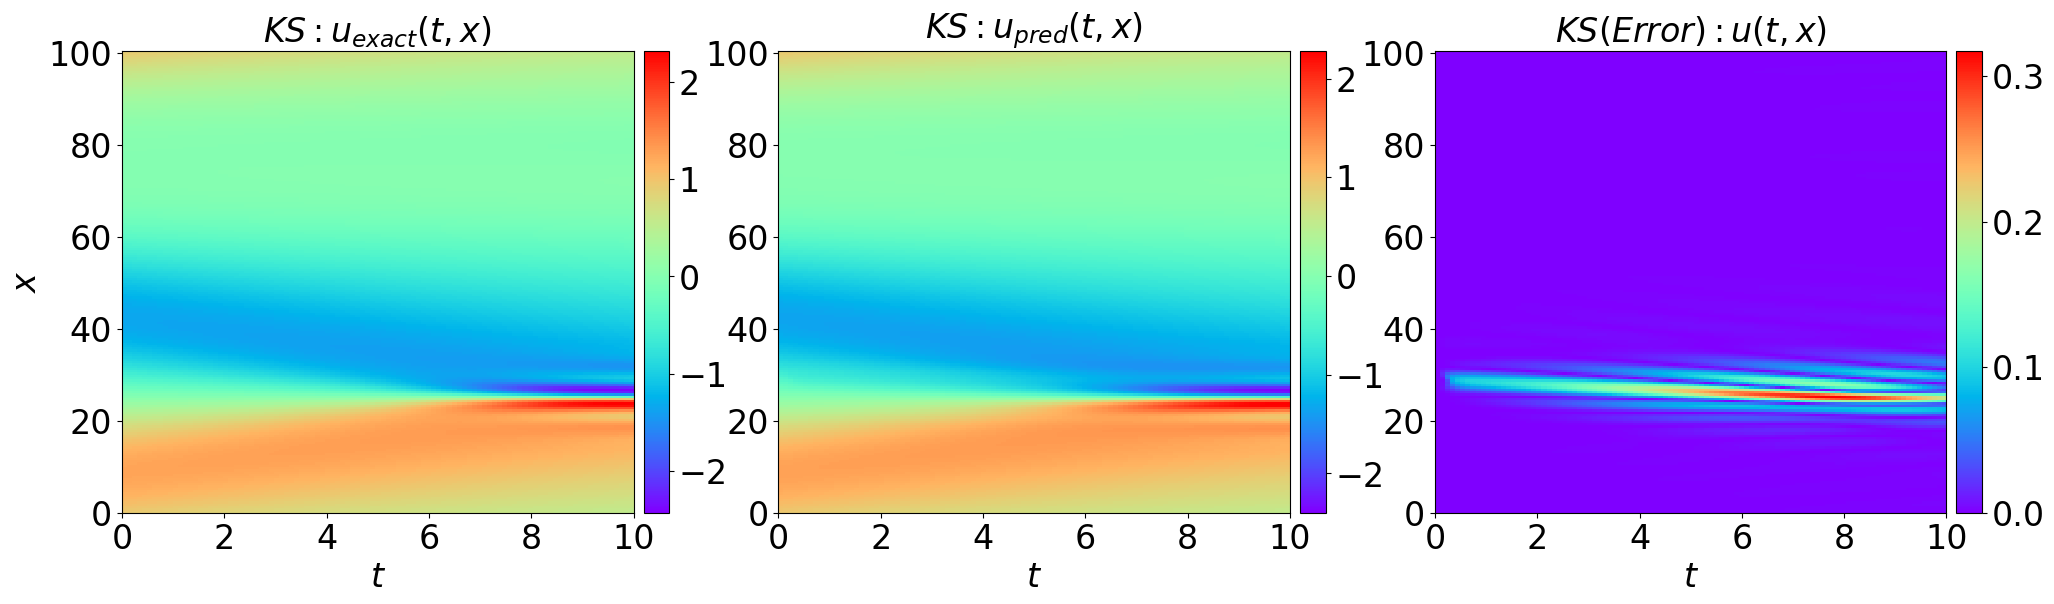

In [16]:
fig = plt.figure(figsize=(24, 6))

ax = plt.subplot(1, 3, 1)
h = ax.imshow(exact_sol.T, interpolation='nearest', cmap='rainbow', 
              extent=[tlo, thi, x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=24) 








ax.set_xlabel('$t$', size=24)
ax.set_ylabel('$x$', size=24)

ax.set_title('$KS: u_{exact}(t,x)$', fontsize = 24) # font size doubled
ax.tick_params(labelsize=24)

ax = plt.subplot(1, 3, 2)
h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
              extent=[tlo, thi, x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=24) 




ax.set_xlabel('$t$', size=24)


ax.set_title('$KS: u_{pred}(t,x)$', fontsize = 24) # font size doubled
ax.tick_params(labelsize=24)

ax = plt.subplot(1, 3, 3)
h = ax.imshow(np.abs(u_pred-exact_sol.T), interpolation='nearest', cmap='rainbow', 
              extent=[tlo, thi, x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=24) 




ax.set_xlabel('$t$', size=24)


ax.set_title('$KS(Error): u(t,x)$', fontsize = 24) # font size doubled
ax.tick_params(labelsize=24)


plt.show()
fig.savefig('KS3_1D_BL+PBC+IC1+SA.png',format='png')